In [689]:

import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt


In [690]:
text = ['edgement']

# Join all the sentences together and extract the unique characters from the combined sentences
chars = set(''.join(text))

# Creating a dictionary that maps integers to the characters
int2char = dict(enumerate(chars))

# Creating another dictionary that maps characters to integers
char2int = {char: ind for ind, char in int2char.items()}

In [691]:
int2char.items()

dict_items([(0, 'n'), (1, 't'), (2, 'g'), (3, 'm'), (4, 'd'), (5, 'e')])

In [692]:
print(int2char)

{0: 'n', 1: 't', 2: 'g', 3: 'm', 4: 'd', 5: 'e'}


In [693]:
len(char2int)

6

In [694]:
maxlen = len(max(text, key=len))

In [695]:
##### Creating the  lists that will hold our input and target sequences
input_seq = []
target_seq = []

for i in range(len(text)):
    # Remove the  last character for input sequence
  input_seq.append(text[i][:-1])
    
    # Remove the first character for target sequence
  target_seq.append(text[i][1:])

  print("Input Sequence: {}\nTarget Sequence: {}".format(input_seq[i], target_seq[i]))

Input Sequence: edgemen
Target Sequence: dgement


In [696]:
for i in range(len(text)):
    input_seq[i] = [char2int[character] for character in input_seq[i]]
    print(input_seq[i])
    target_seq[i] = [char2int[character] for character in target_seq[i]]
    print(target_seq[i])

[5, 4, 2, 5, 3, 5, 0]
[4, 2, 5, 3, 5, 0, 1]


In [697]:
for i in range(len(text)):
    print("Input Sequence: {}\nTarget Sequence: {}".format(input_seq[i], target_seq[i]))

Input Sequence: [5, 4, 2, 5, 3, 5, 0]
Target Sequence: [4, 2, 5, 3, 5, 0, 1]


In [698]:
dict_size = len(char2int)    ##########   Dictionary size :- The number of unique characters that we have in our text 
print(dict_size)
seq_len = maxlen - 1         ##########   The length of the sequences that we are feeding into the model 
print(seq_len)
batch_size = len(text)       ##########   The number of sentences that we defined and are going to feed into the model as a batch
print(batch_size)


6
7
1


In [699]:
dict_size = len(char2int)
seq_len = maxlen - 1
batch_size = len(text)

def one_hot_encode(sequence, dict_size, seq_len, batch_size):
    #######   Creating a multi-dimensional array of zeros with the desired output shape

    
    features = np.zeros((batch_size, seq_len, dict_size), dtype=np.float32)
    print(features)
    
    ######### Replacing the 0 at the relevant character index with a 1 to represent that character


    for i in range(batch_size):
        for u in range(seq_len):
            features[i, u, sequence[i][u]] = 1
    return features

In [700]:
input_seq = one_hot_encode(input_seq, dict_size, seq_len, batch_size)

[[[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]]


In [701]:
print(input_seq)

[[[0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1. 0.]
  [0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 1.]
  [1. 0. 0. 0. 0. 0.]]]


In [702]:
######  we can now move the data from NumPy arrays to PyTorch's very own data structure that is  Torch Tensors.

input_seq = torch.from_numpy(input_seq)  
target_seq = torch.Tensor(target_seq)

In [703]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        #### Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #### Defining the layers
        ###  RNN Layer

        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)

        ### Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):   ######## defining the forward pass function
        
        batch_size = x.size(0)

        ####### Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        #####  Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        ###### Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):    #######  This basically creates a tensor of zeros in the shape of our hidden states.
        ## This method generates the first hidden state of zeros which we will use in the forward pass
        ## We will send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [704]:
##### Instantiate   the model with hyperparameters
model = Model(input_size=dict_size, output_size=dict_size, hidden_dim=5, n_layers=1)

#### Defining the  hyperparameters

n_epochs =100  ## number of epochs  ---------------------------------------------------------------

###### Define Loss, Optimizer ######

criterion = nn.CrossEntropyLoss()

################################################ RmsProp  #########################################################

optimizer = torch.optim.RMSprop(model.parameters(), lr=0.4,alpha = 0.50, eps=1e-18)
# optimizer

# optimizer = torch.optim.Adam(model.parameters(),lr=0.4,betas=(0.9,0.999),eps=1e-08,weight_decay=0,amsgrad=False)

# optimizer = torch.optim.Adagrad(model.parameters(), lr=0.4,eps=1e-18)
optimizer


RMSprop (
Parameter Group 0
    alpha: 0.5
    centered: False
    eps: 1e-18
    lr: 0.4
    momentum: 0
    weight_decay: 0
)

In [705]:
# Training Run
all_losses_3 = [] ##### initializing list of all_losses to maintain all losses inside it .
ep = []         #### initializing list ep to maintain all the corresponding epochs 
##total_loss = 0    # Reset every plot_every iters

for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() ######  Clears existing gradients from previous epoch
    
    output, hidden = model(input_seq)
    loss = criterion(output, target_seq.view(-1).long())
    loss.backward()     ######## Does backpropagation and calculates gradients
    optimizer.step()    ######### Updates the weights accordingly
    
    
    
    if epoch%3 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))
        ep.append(epoch)
        all_losses_3.append(loss)


Epoch: 3/100............. Loss: 1.8898
Epoch: 6/100............. Loss: 0.4998
Epoch: 9/100............. Loss: 0.3467
Epoch: 12/100............. Loss: 0.1721
Epoch: 15/100............. Loss: 0.0273
Epoch: 18/100............. Loss: 0.0106
Epoch: 21/100............. Loss: 0.2162
Epoch: 24/100............. Loss: 0.0102
Epoch: 27/100............. Loss: 0.0044
Epoch: 30/100............. Loss: 0.0025
Epoch: 33/100............. Loss: 0.0014
Epoch: 36/100............. Loss: 0.0006
Epoch: 39/100............. Loss: 0.0003
Epoch: 42/100............. Loss: 0.0005
Epoch: 45/100............. Loss: 0.0001
Epoch: 48/100............. Loss: 0.0000
Epoch: 51/100............. Loss: 0.0000
Epoch: 54/100............. Loss: 0.0000
Epoch: 57/100............. Loss: 0.0000
Epoch: 60/100............. Loss: 0.0000
Epoch: 63/100............. Loss: 0.0000
Epoch: 66/100............. Loss: 0.0000
Epoch: 69/100............. Loss: 0.0000
Epoch: 72/100............. Loss: 0.0002
Epoch: 75/100............. Loss: 0.0000
Epo

In [706]:
# This function takes in the model and character as arguments and returns the next character prediction and hidden state
def predict(model, character):
    ##### One-hot encoding our input to fit into the model
    character = np.array([[char2int[c] for c in character]])
    character = one_hot_encode(character, dict_size, character.shape[1], 1)
    character = torch.from_numpy(character)
    
    
    out, hidden = model(character)

    prob = nn.functional.softmax(out[-1], dim=0).data
    
    #### Taking the class with the highest probability score from the output
    char_ind = torch.max(prob, dim=0)[1].item()

    return int2char[char_ind], hidden

In [707]:
##### This  output function takes the desired output length and input characters as arguments and returns the produced word

def output(model, out_len, start):
    model.eval() 

    ##### First off, run through the starting characters
    chars = [ch for ch in start]
    size = out_len - len(chars)
    
    ##### Now pass in the previous characters and get a new one
    for i in range(size):
        char, h = predict(model, chars)
        chars.append(char)

    return ''.join(chars)

In [708]:
output(model, 8, 'e')

[[[0. 0. 0. 0. 0. 0.]]]
[[[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]]
[[[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]]
[[[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]]
[[[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]]
[[[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]]
[[[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]]


'edgement'

In [709]:
import matplotlib.pyplot as plt 

In [710]:
import torch

tensor1 = torch.tensor(all_losses_1,requires_grad=True)
tensor1 = tensor1.detach().numpy()


In [711]:
import torch

tensor2 = torch.tensor(all_losses_2,requires_grad=True)
tensor2 = tensor2.detach().numpy()


In [712]:
import torch

tensor3 = torch.tensor(all_losses_3,requires_grad=True)
tensor3 = tensor3.detach().numpy()


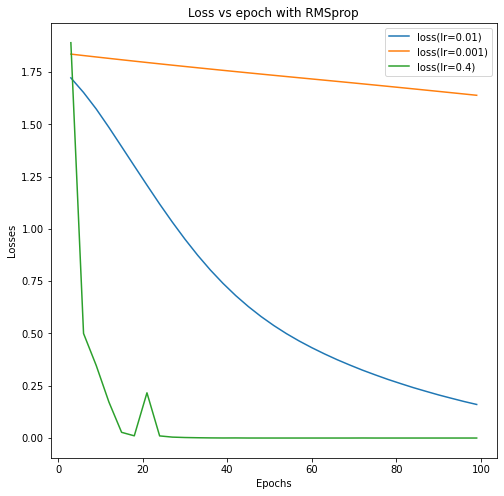

In [713]:
plt.figure(figsize=(8,8))
plt.title("Loss vs epoch with RMSprop")
plt.plot(ep,tensor1, label = "loss(lr=0.01)")
plt.plot(ep,tensor2, label ="loss(lr=0.001)")
plt.plot(ep,tensor3,label ="loss(lr=0.4)")
plt.xlabel("Epochs")
plt.legend()
plt.ylabel("Losses")
plt.show()

In [714]:
all_losses_1

[tensor(1.7216, grad_fn=<NllLossBackward0>),
 tensor(1.6518, grad_fn=<NllLossBackward0>),
 tensor(1.5729, grad_fn=<NllLossBackward0>),
 tensor(1.4850, grad_fn=<NllLossBackward0>),
 tensor(1.3930, grad_fn=<NllLossBackward0>),
 tensor(1.3007, grad_fn=<NllLossBackward0>),
 tensor(1.2089, grad_fn=<NllLossBackward0>),
 tensor(1.1186, grad_fn=<NllLossBackward0>),
 tensor(1.0322, grad_fn=<NllLossBackward0>),
 tensor(0.9502, grad_fn=<NllLossBackward0>),
 tensor(0.8737, grad_fn=<NllLossBackward0>),
 tensor(0.8031, grad_fn=<NllLossBackward0>),
 tensor(0.7391, grad_fn=<NllLossBackward0>),
 tensor(0.6808, grad_fn=<NllLossBackward0>),
 tensor(0.6282, grad_fn=<NllLossBackward0>),
 tensor(0.5807, grad_fn=<NllLossBackward0>),
 tensor(0.5378, grad_fn=<NllLossBackward0>),
 tensor(0.4990, grad_fn=<NllLossBackward0>),
 tensor(0.4639, grad_fn=<NllLossBackward0>),
 tensor(0.4318, grad_fn=<NllLossBackward0>),
 tensor(0.4021, grad_fn=<NllLossBackward0>),
 tensor(0.3744, grad_fn=<NllLossBackward0>),
 tensor(0.

In [715]:
all_losses_2

[tensor(1.8352, grad_fn=<NllLossBackward0>),
 tensor(1.8283, grad_fn=<NllLossBackward0>),
 tensor(1.8215, grad_fn=<NllLossBackward0>),
 tensor(1.8148, grad_fn=<NllLossBackward0>),
 tensor(1.8082, grad_fn=<NllLossBackward0>),
 tensor(1.8016, grad_fn=<NllLossBackward0>),
 tensor(1.7951, grad_fn=<NllLossBackward0>),
 tensor(1.7887, grad_fn=<NllLossBackward0>),
 tensor(1.7823, grad_fn=<NllLossBackward0>),
 tensor(1.7761, grad_fn=<NllLossBackward0>),
 tensor(1.7698, grad_fn=<NllLossBackward0>),
 tensor(1.7637, grad_fn=<NllLossBackward0>),
 tensor(1.7576, grad_fn=<NllLossBackward0>),
 tensor(1.7516, grad_fn=<NllLossBackward0>),
 tensor(1.7456, grad_fn=<NllLossBackward0>),
 tensor(1.7397, grad_fn=<NllLossBackward0>),
 tensor(1.7338, grad_fn=<NllLossBackward0>),
 tensor(1.7279, grad_fn=<NllLossBackward0>),
 tensor(1.7221, grad_fn=<NllLossBackward0>),
 tensor(1.7163, grad_fn=<NllLossBackward0>),
 tensor(1.7106, grad_fn=<NllLossBackward0>),
 tensor(1.7048, grad_fn=<NllLossBackward0>),
 tensor(1.

In [716]:
all_losses_3

[tensor(1.8898, grad_fn=<NllLossBackward0>),
 tensor(0.4998, grad_fn=<NllLossBackward0>),
 tensor(0.3467, grad_fn=<NllLossBackward0>),
 tensor(0.1721, grad_fn=<NllLossBackward0>),
 tensor(0.0273, grad_fn=<NllLossBackward0>),
 tensor(0.0106, grad_fn=<NllLossBackward0>),
 tensor(0.2162, grad_fn=<NllLossBackward0>),
 tensor(0.0102, grad_fn=<NllLossBackward0>),
 tensor(0.0044, grad_fn=<NllLossBackward0>),
 tensor(0.0025, grad_fn=<NllLossBackward0>),
 tensor(0.0014, grad_fn=<NllLossBackward0>),
 tensor(0.0006, grad_fn=<NllLossBackward0>),
 tensor(0.0003, grad_fn=<NllLossBackward0>),
 tensor(0.0005, grad_fn=<NllLossBackward0>),
 tensor(5.6043e-05, grad_fn=<NllLossBackward0>),
 tensor(2.5153e-05, grad_fn=<NllLossBackward0>),
 tensor(1.2977e-05, grad_fn=<NllLossBackward0>),
 tensor(5.9945e-06, grad_fn=<NllLossBackward0>),
 tensor(2.4864e-06, grad_fn=<NllLossBackward0>),
 tensor(9.1961e-07, grad_fn=<NllLossBackward0>),
 tensor(3.9169e-07, grad_fn=<NllLossBackward0>),
 tensor(1.5327e-07, grad_fn